In [1]:
#Let's start by importing the modules we need
#Let's import the modules we need:

%matplotlib notebook
%config Completer.use_jedi = False
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import regex as re

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
#Now let's import the data
train_df=pd.read_csv("Train.csv",index_col=["PhraseId"])
train_df.head()

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,A series of escapades demonstrating the adage ...,1
2,1,A series of escapades demonstrating the adage ...,2
3,1,A series,2
4,1,A,2
5,1,series,2


In [3]:
#Looks like we have the data we need, let's go ahead and extract the Phrase as the train, and the Sentiment as the target
def splitdataset(dataset,ratio=0.95):
    perms=np.random.permutation(len(dataset))
    shuffled_dataset=dataset.iloc[perms]
    train_percentrage=int(len(dataset)*ratio)
    X_train,y_train=shuffled_dataset.iloc[:train_percentrage]["Phrase"],shuffled_dataset.iloc[:train_percentrage]["Sentiment"]
    X_test,y_test=shuffled_dataset.iloc[train_percentrage:]["Phrase"],shuffled_dataset.iloc[train_percentrage:]["Sentiment"]
    return (X_train,y_train),(X_test,y_test)

In [4]:
(X_train,y_train),(X_test,y_test)=splitdataset(train_df)

In [5]:
#Now let's preprocess the data a bit, I am going to first turn these words into one hot encodings using tensorflow, then we
# are going to create embeddings from them. That will come later though

preprocessing_layer=tf.keras.preprocessing.text.Tokenizer(filters="")
preprocessing_layer.fit_on_texts(X_train)

X_train=preprocessing_layer.texts_to_sequences(X_train)
X_test=preprocessing_layer.texts_to_sequences(X_test)

total_words = 20000 # This will be used by the embeding layer
phrase_max_length=75 #This will be used to pad the data

In [6]:
#Creating the padding layer
X_train=tf.keras.preprocessing.sequence.pad_sequences(X_train,maxlen=phrase_max_length,
                                                                      padding="post")
X_test=tf.keras.preprocessing.sequence.pad_sequences(X_test,maxlen=phrase_max_length,
                                                                      padding="post")

In [7]:
#Creating the model using simple GRU layers
embedding_dim=100

model=keras.models.Sequential([
    keras.layers.Embedding(total_words,embedding_dim,input_shape=[phrase_max_length],mask_zero=True),
    keras.layers.LSTM(500,return_sequences=True),
    keras.layers.LSTM(500,return_sequences=True),
    keras.layers.LSTM(500,return_sequences=True),
    keras.layers.LSTM(500,return_sequences=False),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(5,activation="softmax")
])

In [8]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])
history=model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5
4634/4634 [==============================] - 209s 42ms/step - loss: 1.1276 - accuracy: 0.5568 - val_loss: 0.8634 - val_accuracy: 0.6433
Epoch 2/5
4634/4634 [==============================] - 190s 41ms/step - loss: 0.7828 - accuracy: 0.6808 - val_loss: 0.8308 - val_accuracy: 0.6573
Epoch 3/5
4634/4634 [==============================] - 182s 39ms/step - loss: 0.6862 - accuracy: 0.7194 - val_loss: 0.8196 - val_accuracy: 0.6688
Epoch 4/5
4634/4634 [==============================] - 178s 38ms/step - loss: 0.6311 - accuracy: 0.7410 - val_loss: 0.8707 - val_accuracy: 0.6655
Epoch 5/5
4634/4634 [==============================] - 177s 38ms/step - loss: 0.5847 - accuracy: 0.7571 - val_loss: 0.9124 - val_accuracy: 0.6581


In [9]:
#Let's import the data and test it to see how we did 
test_df=pd.read_csv("Test.csv",index_col=["PhraseId"])
test_phrases=test_df["Phrase"]
labels=test_df.index

In [10]:
#Preprocessing and preparring the test data
Test=preprocessing_layer.texts_to_sequences(test_phrases)
Test=tf.keras.preprocessing.sequence.pad_sequences(Test,maxlen=phrase_max_length,
                                                                    padding="post")

In [11]:
results=np.argmax(model.predict(Test),axis=1)
final=np.c_[labels,results]
final_df=pd.DataFrame(final,columns=["PhraseId","Sentiment"])
final_df=final_df.set_index("PhraseId")
final_df.to_csv("Submissions.csv")

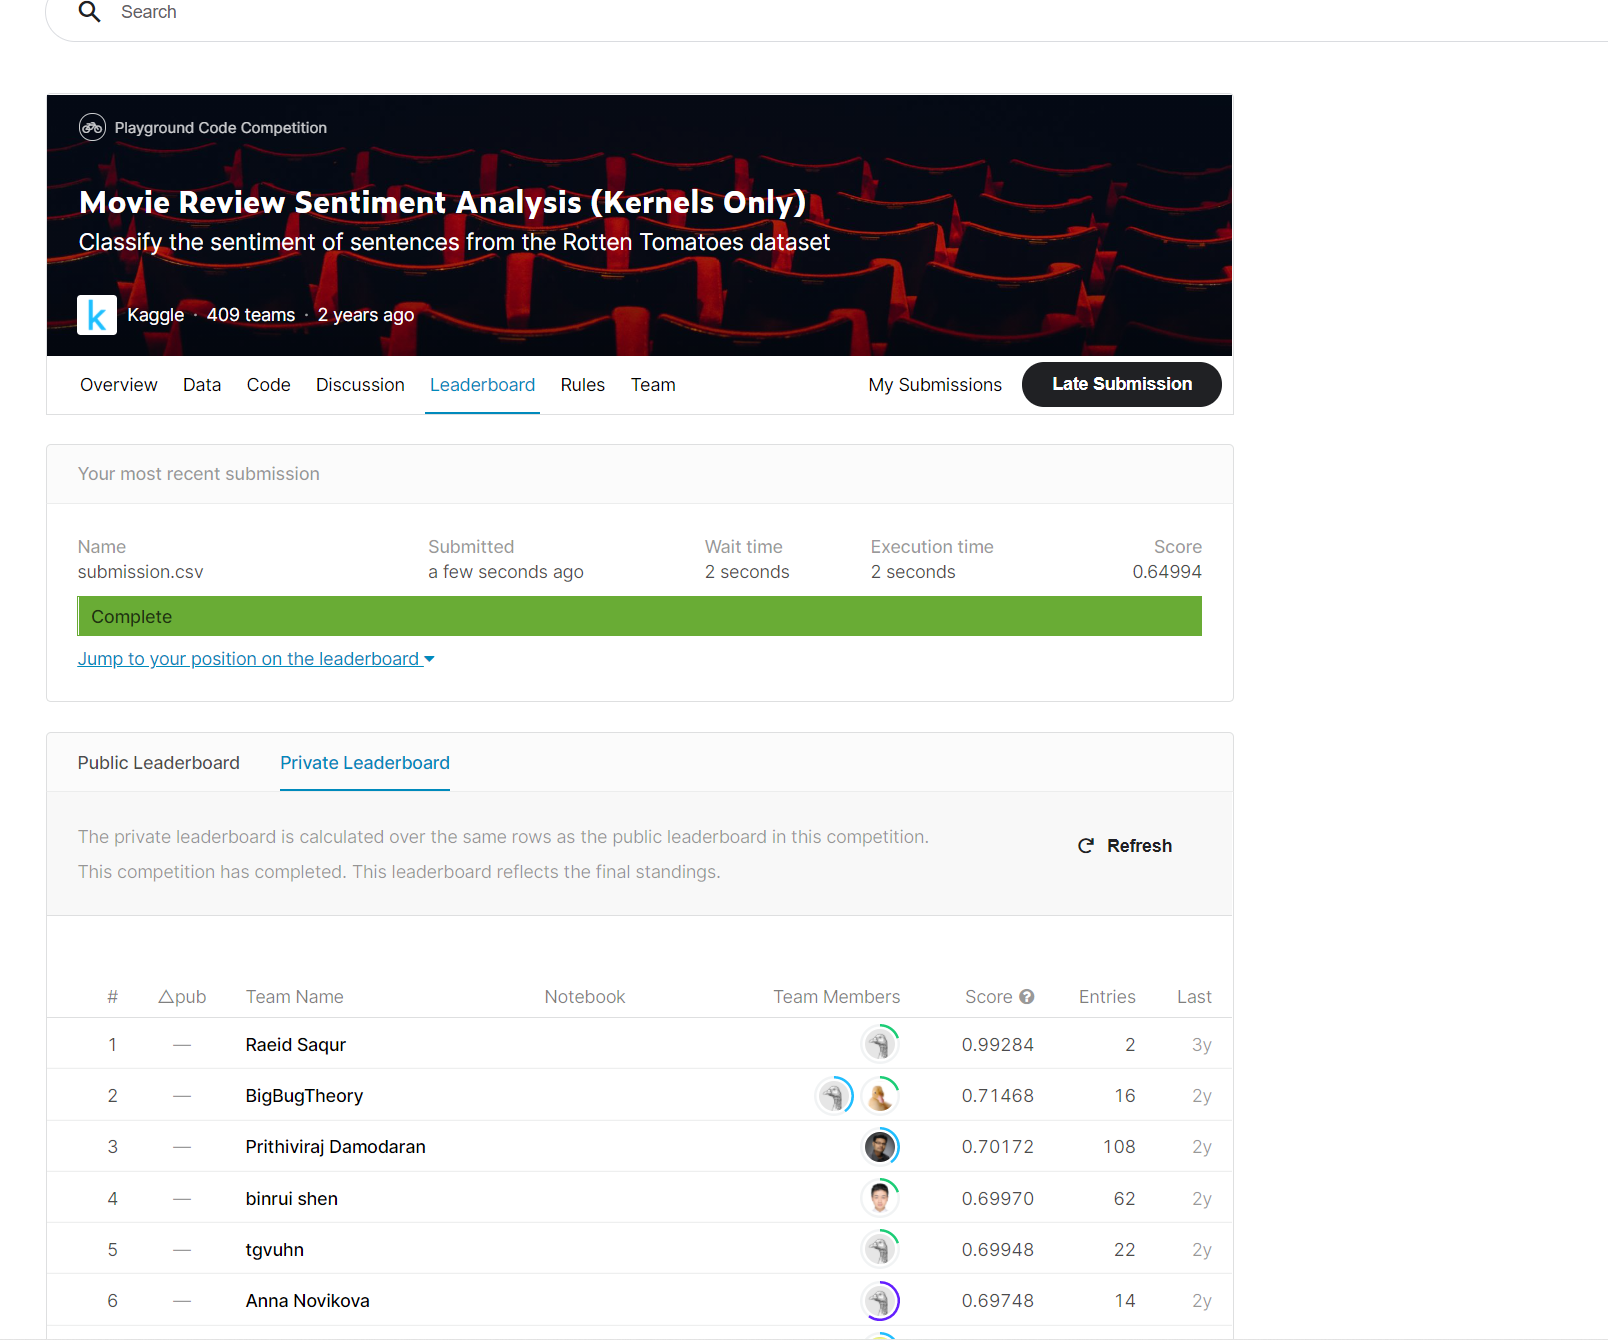

In [12]:
from IPython.display import Image
Image(filename='Sentiment Analysis.png')